# Lab 4 - Ensemble methods
### Analysis of the data set [accidents de voiture en 2021](https://www.data.gouv.fr/fr/datasets/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2021/) on *data.gouv.fr*

We are going to work on three files resulting from a small cleaning of the car accident database for 2021.

carac_accidents_2021.csv : accidents data   
vehicules_2021.csv : vehicle data   
usagers_2021.csv : victims data

The aim is first to perform some exploratory data analysis (EDA), and then to predict the severity of an accident, based on features (type of vehicle, luminosity, speed, etc.)

You should provide answers to the questions marked with the symbol ⏩

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import seaborn as sns

In [3]:
filename = 'accident'

from urllib.request import urlretrieve
urlretrieve("https://bianchi.wp.imt.fr/files/2023/12/accident.zip", filename + '.zip')

import os
zip_file = os.path.join(os.getcwd(), filename + '.zip')

import zipfile
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(os.getcwd())

## Loading Data, Merging into a Single DataFrame, and Cleanups

In [4]:
carac=pd.read_csv("carac_accidents_2021.csv")
carac.tail()

,Num_Acc,jour,mois,an,hrmn,lum,dep,agg,int,atm,col,lat,long,catr,circ,nbv,prof,surf,vma
56513,202100056514,1,1,2021,06:10,3,33,1,1,5,6,"44,5266190000","-0,1955440000",1,3,4,2,2,130
56514,202100056515,1,1,2021,10:20,1,38,1,1,2,6,"45,3802910000","5,7049140000",3,2,2,1,5,80
56515,202100056516,1,1,2021,18:00,3,26,1,1,2,1,"44,9112100000","5,0196360000",3,2,2,2,2,80
56516,202100056517,1,1,2021,10:55,1,33,1,2,1,6,"44,9542747363","-0,5179211363",4,2,2,1,2,80
56517,202100056518,2,1,2021,18:00,3,78,1,1,3,1,"48,7966700000","2,0505000000",3,2,2,1,2,70


In [5]:
vhc=pd.read_csv("vehicules_2021.csv")
vhc.tail()

,Num_Acc,id_vehicule,catv,obs,obsm,motor,occutc
97310,202100056516,100 885,7,0,2,1,NaN
97311,202100056516,100 886,7,0,2,1,NaN
97312,202100056517,100 884,7,6,0,1,NaN
97313,202100056518,100 882,7,0,2,1,NaN
97314,202100056518,100 883,7,0,2,1,NaN


In [6]:
usag=pd.read_csv("usagers_2021.csv")
usag.tail()

,Num_Acc,id_vehicule,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp
129148,202100056516,100 885,1,1,4,1,1975.0,0,1,-1,-1,0,0,-1
129149,202100056516,100 886,1,1,4,1,2002.0,5,1,-1,-1,0,0,-1
129150,202100056517,100 884,1,1,3,1,1999.0,0,0,-1,-1,0,0,-1
129151,202100056518,100 882,1,1,3,1,1968.0,3,1,0,-1,-1,-1,-1
129152,202100056518,100 883,1,1,3,1,1985.0,3,1,0,-1,-1,-1,-1


### Meanings of the different fields in the three data files

#### In *carac_accidents_2021.csv*

Num_Acc: Identification number of the accident. The same in the other DataFrames

day, month, year: day of the accident, month of the accident, year of the accident.

hrmn: hour and minute of the accident.

lum: light, lighting conditions in which the accident occurred:

   1 – Full day

   2 – Dusk or dawn

   3 – Night without public lighting

   4 – Night with public lighting not on

   5 – Night with public lighting on

dep Department: INSEE code (National Institute of Statistics and Economic Studies) of department (2A Corse-du-Sud – 2B Haute-Corse).

agg: location:

   1 – Outside agglomeration

   2 – In built-up areas

int: intersection:

   1 – Out of intersection

   2 – X intersection

   3 – T-junction

   4 – Y intersection

   5 – Intersection with more than 4 branches

   6 – Roundabout

   7 – Square

   8 – Level crossing

   9 – Other intersection


atm: atmospheric conditions:

  -1 – Not filled in

   1 – Normal

   2 – Light rain

   3 – Heavy rain

   4 – Snow - hail

   5 – Fog - smoke

   6 – Strong wind - storm

   7 – Dazzling Time

   8 – Overcast weather

   9 – Other


col: type of collision:

  -1 – Not filled in

   1 – Two vehicles - frontal

   2 – Two vehicles – from behind

   3 – Two vehicles – from the side

   4 – Three or more vehicles – in a chain

   5 – Three or more vehicles - multiple collisions

   6 – Other Collision

   7 – Collision free


lat : latitude

Length: longitude

catr: road category:

   1 – Motorway

   2 – National road

   3 – Departmental Road

   4 – Communal roads

   5 – Outside the public network

   6 – Car park open to public traffic

   7 – Urban Metropolis Routes

   9 – other



circ: circulation regime:

  -1 – Not filled in

   1 – One way

   2 – Bidirectional

   3 – With separate carriageways

   4 – With variable assignment channels

nbv: total number of traffic lanes.

prof: longitudinal profile, describes the slope of the road at the place of the accident:

  -1 – Not filled in

   1 – Flat

   2 – Slope

   3 – Top of the hill

   4 – Bottom of the coast


surf: surface condition:

  -1 – Not filled in

   1 – Normal

   2 – Wet

   3 – Puddles

   4 – Flooded

   5 – Snowy

   6 – Mud

   7 – Icy

   8 – Fats – oil

   9 – Other

vma

Maximum authorized speed at the place and at the time of the accident.


#### In *vehicles_2021.csv*

Num_Acc: identifier of the accident identical to that of the "carac_accidents_2021" file included for each of the described vehicles involved in the accident.

id_vehicule: vehicle identifier

catv: vehicle category:

   00 – Indeterminable

   01 – Bicycle

   02 – Moped <50cm3

   03 – Cart (Quadricycle with bodied motor) (formerly "cart or motor tricycle")

   04 – Reference unused since 2006 (registered scooter)

   05 – Unused reference since 2006 (motorcycle)

   06 – Reference unused since 2006 (sidecar)

   07 – LV only

   08 – Reference unused since 2006 (VL + caravan)

   09 – Reference unused since 2006 (VL + trailer)

   10 – LCV only 1.5T <= GVW <= 3.5T with or without trailer (formerly LCV only 1.5T <= GVW       <= 3.5T)

   11 – Reference unused since 2006 (VU (10) + caravan)

   12 – Reference unused since 2006 (VU (10) + trailer)

   13 – PL only 3.5T <PTCA <= 7.5T

   14 – PL only > 7.5T

   15 – HGV > 3.5T + trailer

   16 – Road tractor only

   17 – Road tractor + semi-trailer

   18 – Reference unused since 2006 (public transport)

   19 – Reference unused since 2006 (tramway)

   20 – Special gear

   21 – Agricultural tractor

   30 – Scooter < 50 cc

   31 – Motorcycle > 50 cm3 and <= 125 cm3

   32 – Scooter > 50 cm3 and <= 125 cm3

   33 – Motorcycle > 125 cm3

   34 – Scooter > 125 cc

   35 – Light quad <= 50 cc (Unbodied motor quadricycle)

   36 – Heavy quad > 50 cm3 (Quadricycle with motor without bodywork)

   37 – Buses

   38 – Bus

   39 – Train

   40 – Tramway

   41 – 3WD <= 50cc

   42 – 3WD > 50cc <= 125cc

   43 – 3WD > 125 cc

   50 – Motor EDP

   60 – EDP without engine

   80 – eBike

   99 – Other vehicle



obs: fixed obstacle struck:

  -1 – Not filled in

   0 – Not applicable

   1 – Parked vehicle

   2 – Tree

   3 – Metal slider

   4 – Concrete slide

   5 – Other slide

   6 – Building, wall, bridge pier

   7 – Vertical signaling support or emergency call station

   8 – Pole

   9 – Street furniture

  10 – Parapet

  11 – Island, refuge, high boundary

  12 – Sidewalk curb

  13 – Ditch, embankment, rock face

  14 – Other fixed obstacle on roadway

  15 – Other fixed obstacle on sidewalk or shoulder

  16 – Obstacle-free road exit

  17 – Nozzle – aqueduct head


motor: type of vehicle engine:

  -1 – Not filled in

   0 – Unknown

   1 – Hydrocarbons

   2 – Electric hybrid

   3 – Electrical

   4 – Hydrogen

   5 – Human

   6 – Other

occutc: number of occupants in public transport.


#### In *users_2021.csv*

Num_Acc and id_vehicule: the same as in the previous file.

seat: allows you to locate the seat occupied in the vehicle by the user at the time of the accident, see the file
         "description ... pdf"

catu: user category:

   1 – Driver

   2 – Passenger

   3 – Pedestrian



**severity: severity of user injury, injured users are classified into three categories of
        victims plus uninjured:**

   1 – Free

   2 – Killed

   3 – Wounded hospitalized

   4 – Slightly injured

**Our classification algorithm will estimate the severity of the accident.**


gender: gender of user:

   1 – Male

   2 – Feminine


An_nais: year of birth of the user.

journey: reason for travel at the time of the accident:

  -1 – Not filled in

   0 – Not filled in

   1 – Home – work

   2 – Home – school

   3 – Shopping – purchases

   4 – Professional use

   5 – Walk – leisure

   9 – Other


From 2019, this is the use with up to 3 possible equipment for the same user
(especially for motorcyclists whose helmet and gloves are compulsory).

secu1, secu2, secu3: the information of the character indicates the presence and the use of the equipment of
    security :

  -1 – Not filled in

   0 – No equipment

   1 – Belt

   2 – Helmet

   3 – Children device

   4 – Reflective vest

   5 – Airbag (2WD/3WD)

   6 – Gloves (2WD/3WD)

   7 – Gloves + Airbag (2WD/3WD)

   8 – Not determinable

   9 – Other

locp: location of the pedestrian:

  -1 – Not filled in

   0 – Not applicable

  On pavement:

   1 – More than 50 m from the pedestrian crossing

   2 – Less than 50 m from the pedestrian crossing

  On pedestrian crossing:

   3 – Without light signaling

   4 – With light signaling

  Various :

   5 – On sidewalk

   6 – On shoulder

   7 – On refuge or emergency lane

   8 – On counter aisle

   9 – Unknown


actp pedestrian action:

   -1 – Not filled in

  Moving

    0 – Not filled in or not applicable

    1 – Direction of vehicle hitting

    2 – Reverse direction of the vehicle

  Various

    3 – Crossing

    4 – Hidden

    5 – Playing – running

    6 – With animal

    9 – Other

    A – Getting in/out of the vehicle

    B – Unknown

etatp: this variable is used to specify whether the injured pedestrian was alone or not:

   -1 – Not filled in

    1 – Alone

    2 – Accompanied

    3 – In a group



We find that there were 56,518 accidents in 2021 which involved 97,315 vehicles and 129,153 people.

Remember that Num_Acc, the identifier of the accident, is a column common to the three DataFrames. To an accident number corresponds a single line in charac and in general several lines in the two other DataFrames because an accident involves more than one vehicle and more than one person in general. You can check this, for example with the unique() and nunique() methods, or with value_counts()

In [7]:
print('Min and max number of vehicles per accident : ',min(vhc['Num_Acc'].value_counts()), max(vhc['Num_Acc'].value_counts()))
print('Min and max number of users per accident : ', min(usag['Num_Acc'].value_counts()),  max(usag['Num_Acc'].value_counts()))

Min and max number of vehicles per accident :  1 20
Min and max number of users per accident :  1 24


We will now create a large DF that groups all the data. To an entry in DF usag corresponds one or more entries in DF vhc, and to an entry in vhc corresponds one or more entries in DF carac.

The large DF will therefore have the dimensions of the used DF.

The merge() method documented [here](https://pandas.pydata.org/docs/reference/api/pandas.merge.html) and [there](https://realpython.com/pandas-merge-join -and-concat/) is made to achieve this type of merge

For illustration, here is a basic example of using merge()

In [8]:
df1 = pd.DataFrame({'key': ['aa', 'bb', 'ba', 'aa', 'tt'],'value': [1, 2, 3, 5, 10]})
df2 = pd.DataFrame({'key': ['aa', 'bb', 'ba', 'tu', 'bb'],'value': [5, 6, 7, 20, 50]})

In [9]:
df1

,key,value
0,aa,1
1,bb,2
2,ba,3
3,aa,5
4,tt,10


In [10]:
df2

,key,value
0,aa,5
1,bb,6
2,ba,7
3,tu,20
4,bb,50


In [11]:
# Merge on the common 'key' column based on the left DF: if value is missing in the 'key' column
# of the right DF, add a NaN
print(df1.merge(df2, on='key',how='left'))

print('\n')

# Merge on the common 'key' column based on the intersection: only the values common to both
# columns are taken into account
print(df1.merge(df2, on='key',how='inner'))

  key  value_x  value_y
0  aa        1      5.0
1  bb        2      6.0
2  bb        2     50.0
3  ba        3      7.0
4  aa        5      5.0
5  tt       10      NaN


  key  value_x  value_y
0  aa        1        5
1  aa        5        5
2  bb        2        6
3  bb        2       50
4  ba        3        7


Back to our three DFs: we merge vhc -> usag based on the common 'Num_Acc' and 'id_vehicule' columns, then we merge carac -> the resulting DF based on the common 'Num_Acc' column

In [12]:
accid=usag.merge(vhc, on=['Num_Acc','id_vehicule'],how='left').merge(carac,on='Num_Acc',how='left')
accid.tail()

,Num_Acc,id_vehicule,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,...,atm,col,lat,long,catr,circ,nbv,prof,surf,vma
129148,202100056516,100 885,1,1,4,1,1975.0,0,1,-1,...,2,1,"44,9112100000","5,0196360000",3,2,2,2,2,80
129149,202100056516,100 886,1,1,4,1,2002.0,5,1,-1,...,2,1,"44,9112100000","5,0196360000",3,2,2,2,2,80
129150,202100056517,100 884,1,1,3,1,1999.0,0,0,-1,...,1,6,"44,9542747363","-0,5179211363",4,2,2,1,2,80
129151,202100056518,100 882,1,1,3,1,1968.0,3,1,0,...,3,1,"48,7966700000","2,0505000000",3,2,2,1,2,70
129152,202100056518,100 883,1,1,3,1,1985.0,3,1,0,...,3,1,"48,7966700000","2,0505000000",3,2,2,1,2,70


In [13]:
accid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129153 entries, 0 to 129152
Data columns (total 37 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Num_Acc      129153 non-null  int64  
 1   id_vehicule  129153 non-null  object 
 2   place        129153 non-null  int64  
 3   catu         129153 non-null  int64  
 4   grav         129153 non-null  int64  
 5   sexe         129153 non-null  int64  
 6   an_nais      126086 non-null  float64
 7   trajet       129153 non-null  int64  
 8   secu1        129153 non-null  int64  
 9   secu2        129153 non-null  int64  
 10  secu3        129153 non-null  int64  
 11  locp         129153 non-null  int64  
 12  actp         129153 non-null  object 
 13  etatp        129153 non-null  int64  
 14  catv         129153 non-null  int64  
 15  obs          129153 non-null  int64  
 16  obsm         129153 non-null  int64  
 17  motor        129153 non-null  int64  
 18  occutc       1353 non-nu

In [14]:
# We change the latitude and longitude to float. Previously, you have to replace the comma in these fields with a period
accid['long']=accid['long'].str.replace(',','.').astype(float)
accid['lat']=accid['lat'].str.replace(',','.').astype(float)

In [15]:
accid.tail()

,Num_Acc,id_vehicule,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,...,atm,col,lat,long,catr,circ,nbv,prof,surf,vma
129148,202100056516,100 885,1,1,4,1,1975.0,0,1,-1,...,2,1,44.911210,5.019636,3,2,2,2,2,80
129149,202100056516,100 886,1,1,4,1,2002.0,5,1,-1,...,2,1,44.911210,5.019636,3,2,2,2,2,80
129150,202100056517,100 884,1,1,3,1,1999.0,0,0,-1,...,1,6,44.954275,-0.517921,4,2,2,1,2,80
129151,202100056518,100 882,1,1,3,1,1968.0,3,1,0,...,3,1,48.796670,2.050500,3,2,2,1,2,70
129152,202100056518,100 883,1,1,3,1,1985.0,3,1,0,...,3,1,48.796670,2.050500,3,2,2,1,2,70


# PART I.  Exploratory Data Analysis (EDA)

⏩ Run the cell below, which is the map of accidents involving death casualties. You should see a cluster of points. What does this cluster correspond to? What do the other (sparser) points represent?

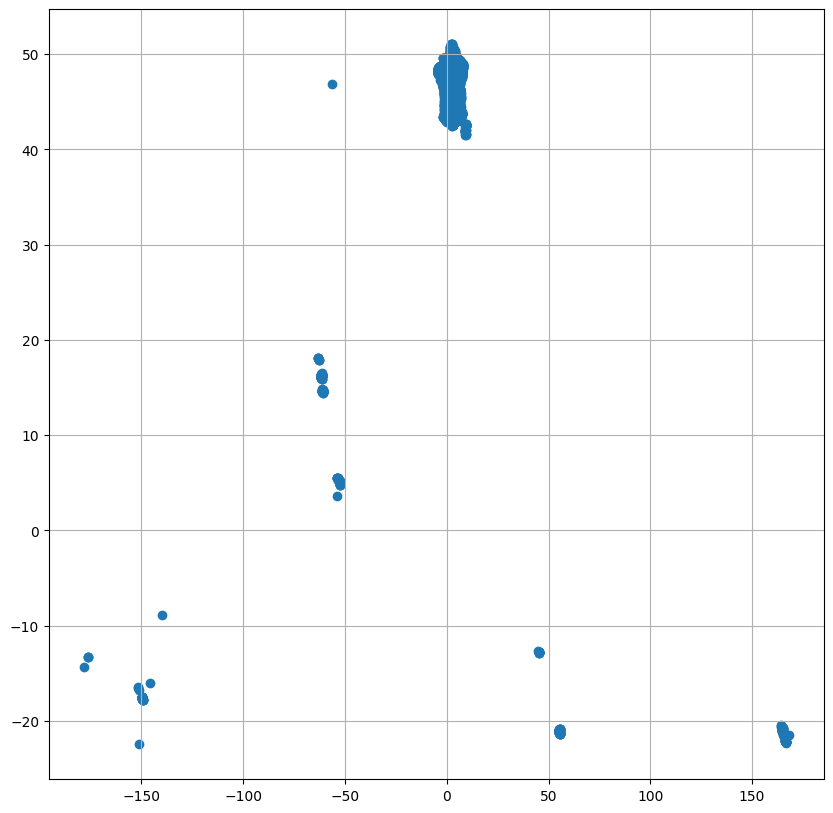

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
ax.grid()
# Map of killed
killed=accid[accid['grav']==2]
ax.scatter(killed['long'],killed['lat'])

On the figure latitude is plotted against the longitude.
The cluster represents the metropolitan France. The sparse points represent other french territories around the world.

⏩ Let us zoom: complete the code

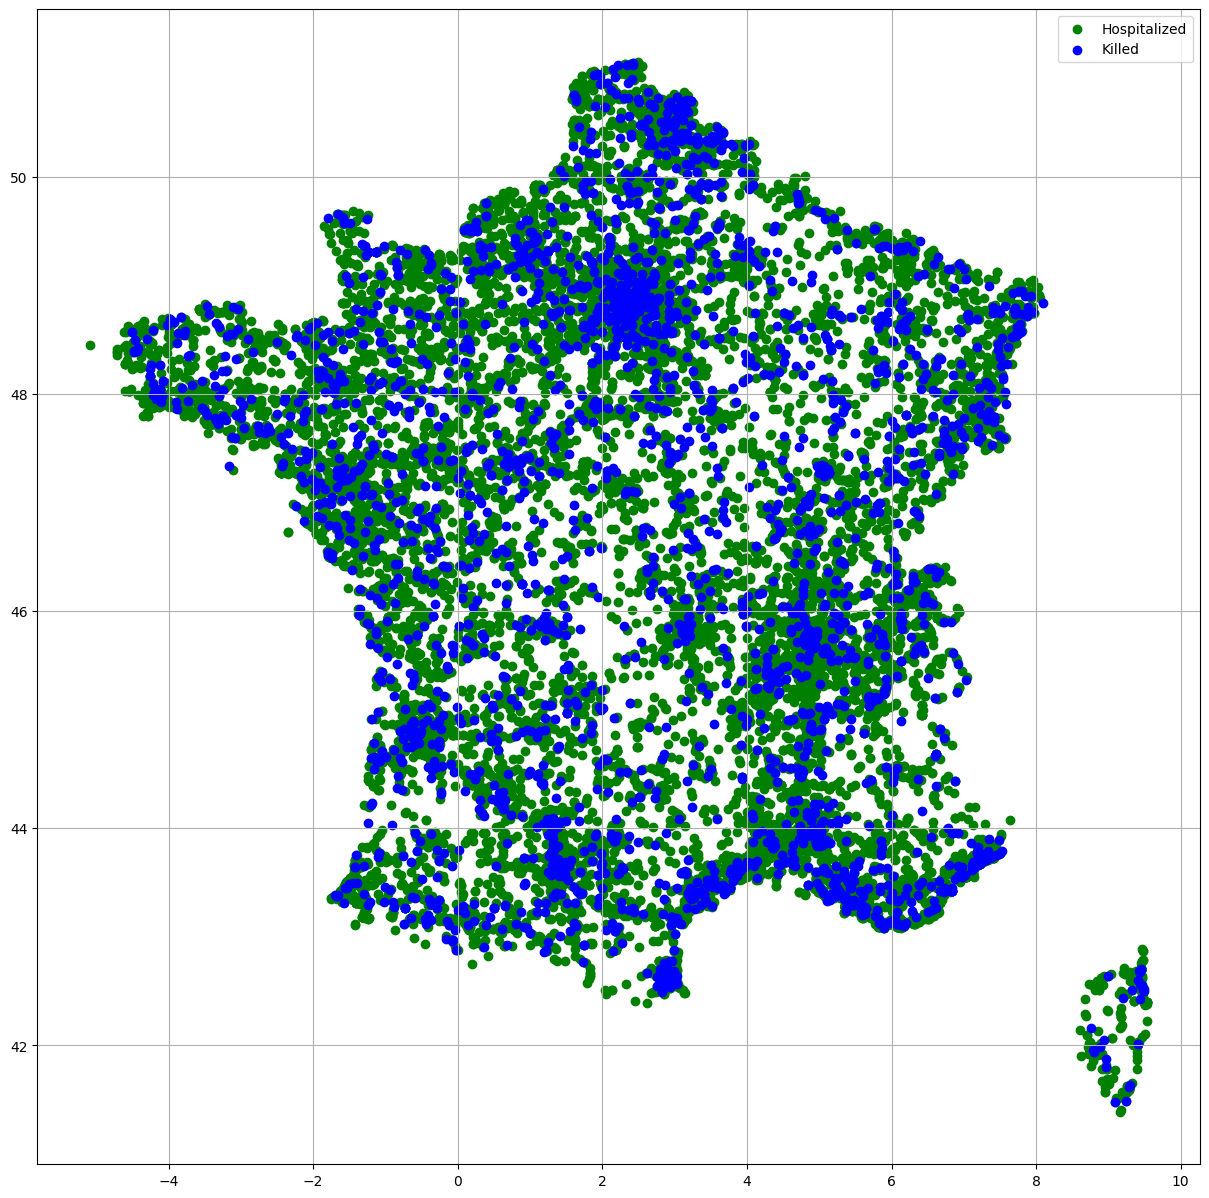

In [17]:
fig, ax = plt.subplots(figsize=(15,15))
ax.grid()

accid_met=accid[(accid['long'] >= -25) & (accid['lat'] >= 40)]

line1=ax.scatter(accid_met[accid_met['grav']==3]['long'],accid_met[accid_met['grav']==3]['lat'],color='green',label='Hospitalized')
line2=ax.scatter(accid_met[accid_met['grav']==2]['long'],accid_met[accid_met['grav']==2]['lat'],color='blue',label='Killed')
ax.legend(handles=[line1, line2])

⏩ How many people killed in 2021? What is the proportion of deadly accidents?

In [18]:
print(accid['grav'].value_counts())
print(accid['grav'].value_counts() / len(accid))

 1    55108
 4    51681
 3    19085
 2     3219
-1       60
Name: grav, dtype: int64
 1    0.426688
 4    0.400153
 3    0.147770
 2    0.024924
-1    0.000465
Name: grav, dtype: float64


As per dataset description, "2" means that the person was killed. Thus, in that year, 3219 people were killed, which is 2.5% of all people involved in accidents

⏩ Comment the output of the cells below

In [19]:
print(accid['sexe'].value_counts())

 1    86196
 2    39895
-1     3062
Name: sexe, dtype: int64


There were 86k of males involved in accidents, and only 40k of females involved. 3k of entries contain N/A.

In [20]:
print('Repartition of men casualties : \n', accid[accid['sexe']==1]['grav'].value_counts(), '\n')
print('Repartition of women casualties : \n', accid[accid['sexe']==2]['grav'].value_counts())

Repartition of men casualties : 
 1    37163
4    32873
3    13640
2     2520
Name: grav, dtype: int64 

Repartition of women casualties : 
 4    18808
1    14943
3     5445
2      699
Name: grav, dtype: int64


Approximately 3% of males are killed (more than average), and 1.8% of females.
However, on average, male is the most likely to end up uninjured (1), and female is most likely to end up slightly injured (4).

In [21]:
print('Accidents in built-up areas (2) and outside built-up areas (1) ; \n ',accid['agg'].value_counts(), '\n')
print('Repartition of accidents in built-up areas : \n', accid[accid['agg']==2]['grav'].value_counts(), '\n')
print('Repartition of accidents outside built-up areas : \n', accid[accid['agg']==1]['grav'].value_counts(), '\n')

Accidents in built-up areas (2) and outside built-up areas (1) ; 
  2    80749
1    48404
Name: agg, dtype: int64 

Repartition of accidents in built-up areas : 
  1    36526
 4    34024
 3     9079
 2     1067
-1       53
Name: grav, dtype: int64 

Repartition of accidents outside built-up areas : 
  1    18582
 4    17657
 3    10006
 2     2152
-1        7
Name: grav, dtype: int64 



More accidents happen in built-up areas. Additionally, in built up areas 45% of people are left uninjured, whereas outside those areas it is only ~26%. As well, on average much more people get wounded and hospitalized(3), or killed(2) outside built-up areas. In my opinion, this could be attributed to the fact that vehicles drive faster outside those areas.

### Formatting data for processing by the ML algorithm

Most features are categorical.
We will examine them one by one, possibly eliminating them, cleaning them up and categorizing them when necessary.
Some rules :
- If instances of a categorical feature are infrequent, they are combined into a single instance to avoid overfitting, otherwise the OneHot encoding will create too many new ones
unrepresentative columns,
- If the feature supposed to be numeric contains NaN, put them say at the average value of the numeric instances,
- If the digital feature contains an outlier, clip it,
- If "common sense" tells us that a feature is unlikely to have an impact on the performance of the algorithm, we eliminate it outright.

In [22]:
# First of all, let's identify the possible lines for which the severity of the accident is unknown
accid['grav'].value_counts()

 1    55108
 4    51681
 3    19085
 2     3219
-1       60
Name: grav, dtype: int64

We drop the 60 accident of unknown severity from the data set

In [23]:
# There are 60 accidents of unknown severity. We eliminate them.
accid.drop(accid[accid['grav'] == -1].index, inplace = True)

⏩ Create a new column named `severe`, whose value is equal to one if the accident has severity `grav` 2 (hospital) or 3 (killed), and zero otherwise.

In [24]:
accid['severe'] = accid['grav'].apply(lambda x:int(x==2 or x==3))

⏩ What is the ratio of severe accidents among all accidents?

In [25]:
accid['severe'].value_counts() / len(accid["severe"])

0    0.827225
1    0.172775
Name: severe, dtype: float64

17% of accidents are severe

⏩ We investigate the 'place' feature. Explain what the following code is doing.

In [26]:
print(accid['place'].value_counts())
pd.get_dummies(accid['place']).corrwith(accid['severe'])

1     96985
2     14452
10     9474
3      2474
4      2228
9      1187
7      1101
5       608
8       437
6       147
Name: place, dtype: int64


1    -0.055343
2    -0.002466
3    -0.022634
4    -0.023905
5    -0.007795
6    -0.002064
7     0.015102
8     0.005820
9     0.008784
10    0.111036
dtype: float64

This code first outputs the number of accidents at each place (we see that places 5,6,8 have very little amount of accidents). Next, the code outputs the correlation of the severity of injuries and the place of accident.

For example places from 1 to 6 correlate with less severe accidents, and places 7-10 with more severe.

Places -1, 6, 8 and 5 are not very representative and have little correlation with the severity of the accident. We will merge them into a single value, for example 20.

In [27]:
accid.place.replace([-1,6,8,5], 20,inplace=True)

⏩ Inspect the catu attribute (1=driver, 2=passenger, 3=pedestrian). Which of these values is the most correlated with the severity of the accident?

In [28]:
pd.get_dummies(accid['catu']).corrwith(accid['severe'])

1   -0.055758
2   -0.012967
3    0.111036
dtype: float64

Pedestrians (3) value is the most correlated.

⏩ Inspect the 'trajet' column. What type of travel seems to be correlated with severe injuries?

In [29]:
pd.get_dummies(accid["trajet"]).corrwith(accid["severe"])

-1   -0.069031
 0   -0.039289
 1   -0.020816
 2   -0.004075
 3    0.030191
 4   -0.088147
 5    0.131597
 9   -0.025498
dtype: float64

5 = Walk-leisure is the most correlated

⏩ Inspect the 'an_nais' column, which corresponds to the birth year. In case you find that there are missing values, do something appropriate.

In [30]:
accid['an_nais'].isnull().sum()

3007

In [31]:
accid["an_nais"] = accid["an_nais"].fillna(accid['an_nais'].mean())

we fill null values with the mean birth year.

We transform secu1, secu2 and secu3 => security equipment.

 There are three columns because a user can use up to three devices.

 We do a OneHot encoding "by hand"

In [32]:
accid['belt'] = accid[['secu1','secu2','secu3']].apply(lambda x:int((x[0]==1)|(x[1]==1)|(x[2]==1)),axis=1)
accid['helmet'] = accid[['secu1','secu2','secu3']].apply(lambda x:int((x[0]==2)|(x[1]==2)|(x[2]==2)),axis=1)
accid['child_equip'] = accid[['secu1','secu2','secu3']].apply(lambda x:int((x[0]==3)|(x[1]==3)|(x[2]==3)),axis=1)
accid['airbag'] = accid[['secu1','secu2','secu3']].apply(lambda x:int((x[0]==5)|(x[1]==5)|(x[2]==5)),axis=1)
accid['no_equip'] = accid[['secu1','secu2','secu3']].apply(lambda x:int((x[0]==0)&(x[1]==0)&(x[2]==0)),axis=1)


⏩ Drop 'secu1','secu2','secu3' columns

In [33]:
accid.drop(columns=["secu1", "secu2", "secu3"], inplace=True)

Inspect the vma columns, which corresponds to the maximal speed in km/h. Draw a boxplot of the column. Are some values absurd?

<Axes: >

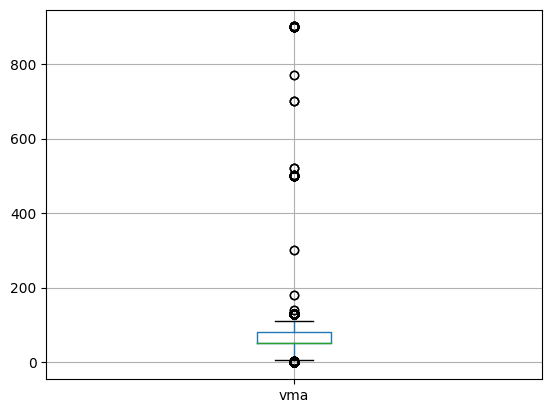

In [34]:
accid[["vma"]].boxplot()

We see on the boxplot outliers which have very hight values. For example, above 400 km/h

⏩ What is the following code doing?

In [35]:
accid['vma_clipped'] = accid['vma'].clip(lower = 0, upper = 130)

If entry has value >130, it will assign 130 to it. If value < 0, then it assigns 0 to it.

# PART 2. Binary Classification
We propose to keep the following columns. Note that there are many columns for which we did not use any feature engineering or cleansing, feel free to do it in order to improve the results!

In [36]:
columns_to_keep = ['place', 'catu', 'sexe', 'an_nais',
       'trajet', 'lum', 'agg','surf',
       'atm',  'belt', 'helmet', 'child_equip', 'airbag', 'no_equip',
       'vma_clipped','locp',  'etatp', 'catv', 'obs', 'obsm', 'motor', 'int','catr', 'circ', 'nbv', 'prof']
accid[columns_to_keep].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129093 entries, 0 to 129152
Data columns (total 26 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   place        129093 non-null  int64  
 1   catu         129093 non-null  int64  
 2   sexe         129093 non-null  int64  
 3   an_nais      129093 non-null  float64
 4   trajet       129093 non-null  int64  
 5   lum          129093 non-null  int64  
 6   agg          129093 non-null  int64  
 7   surf         129093 non-null  int64  
 8   atm          129093 non-null  int64  
 9   belt         129093 non-null  int64  
 10  helmet       129093 non-null  int64  
 11  child_equip  129093 non-null  int64  
 12  airbag       129093 non-null  int64  
 13  no_equip     129093 non-null  int64  
 14  vma_clipped  129093 non-null  int64  
 15  locp         129093 non-null  int64  
 16  etatp        129093 non-null  int64  
 17  catv         129093 non-null  int64  
 18  obs          129093 non-

⏩ Perform the train-test split, keeping only the above `columns_to_keep` list

So far, we are only interested in binary classification, so the label column would be `accid['severe']`. However, we will later be interested in multiclass classification. Therefore, you can have two label columns `accid[['severe','grav']]`

In [37]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(accid[columns_to_keep], accid[['severe','grav']],train_size=0.66) #split 1/3 for test

⏩ Run the next cell. If one had to use onehot encoding, how many columns would we have?

In [105]:
x_train.nunique()

place            8
catu             3
sexe             3
an_nais        105
trajet           8
lum              5
agg              2
surf            10
atm             10
belt             2
helmet           2
child_equip      2
airbag           2
no_equip         2
vma_clipped     24
locp            11
etatp            4
catv            32
obs             19
obsm             8
motor            8
int              9
catr             8
circ             5
nbv             14
prof             5
dtype: int64

In [106]:
x_train.nunique().sum()

311

we would have 311 columns, if we used one hot encoding. Because for each feature we need 1 separate column for each unique value there. This would be a lot of columns..

Running value_counts() on some columns, we observe that some values are quite rare. They bring complexity into the model, but little information to learn from. It might be wise to merge rare values into a single "bin". We do not handle this here, but you may try this at home if you wish.

In [39]:
x_train['surf'].value_counts()

 1    68875
 2    15056
 7      398
 9      328
 5      226
 3      113
 8      100
 6       55
 4       34
-1       16
Name: surf, dtype: int64

## Decision tree
⏩ Train a decision tree, using the default parameters.

In [40]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
y_train0 = y_train["severe"]
dt.fit(x_train, y_train0)

DecisionTreeClassifier()

⏩ Compute the accuracy score. You should find something around 80% of correct predictions. Not bad for a decision tree?

In [41]:
from sklearn.metrics import accuracy_score
y_test0 = y_test["severe"]
accuracy_score(dt.predict(x_test), y_test0)

0.7922628269388499

⏩ Compare the accuracy of the classifier which outputs "0" for every input, and explain.

In [42]:
accuracy_score(np.zeros(len(y_test0)), y_test0)

0.8276451289528843

This shows that decision tree performs even worse, than simply guessing the lable.

⏩ Compute the area under the ROC curve for the decision tree

In [43]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test0, dt.predict_proba(x_test)[:,1])

0.6495322932434732

## Random Forest
⏩ Train a random forest classifier, using the default parameters.

Provide the accuracy score and the AUC.


In [44]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(x_train, y_train0)

print("Accuracy score: ", accuracy_score(rf.predict(x_test), y_test0))
print("Area under the ROC curve: ", roc_auc_score(y_test0, rf.predict_proba(x_test)[:,1]))

Accuracy score:  0.8499270937756311
Area under the ROC curve:  0.8428856390394287


The accuracy is better than for single decision tree

⏩ Now set `min_samples_split` to a higher value than the default value 2. Compare the performance, and explain.



min_samples_split=2, Accuracy = 0.8502688417023604
min_samples_split=7, Accuracy = 0.8554406269935295
min_samples_split=12, Accuracy = 0.856443087578602
min_samples_split=17, Accuracy = 0.8564886539688326
min_samples_split=22, Accuracy = 0.8570810170418299
min_samples_split=27, Accuracy = 0.8576733801148273


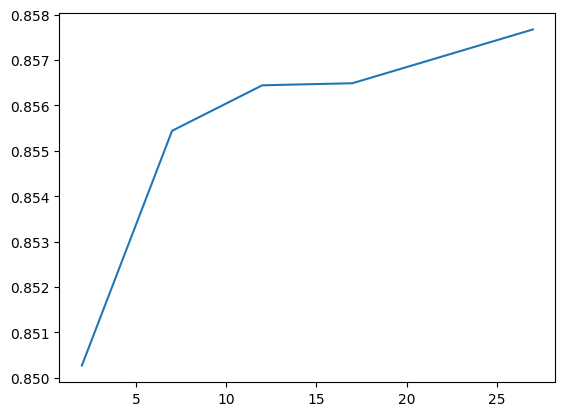

In [45]:
accuracy = []
param_range = range(2,30,5)
for i in param_range:
  rf = RandomForestClassifier(min_samples_split=i)
  rf.fit(x_train, y_train0)
  print(f"min_samples_split={i}, Accuracy = {accuracy_score(rf.predict(x_test), y_test0)}")
  accuracy.append(accuracy_score(rf.predict(x_test), y_test0))

plt.plot(list(param_range), accuracy)
plt.show()

This parameter specifies the minimum required data points in a decision region, to split it further. If this parameter is low, the space will be split into more decision regions, and vice versa. This parameter helps avoiding overfitting. Performance is slightly improved, when this parameter is greater than 2

⏩ What does the `n_estimators` parameter refers to? What is the default value? You may try to play with this parameter if time permits.

This parameter specifies the number of decision trees in the random forest. The default value is set to 100.

⏩ Explain what `rf.feature_importances_` refers to. Plot bars of feature importances. Comment the result.

<Axes: >

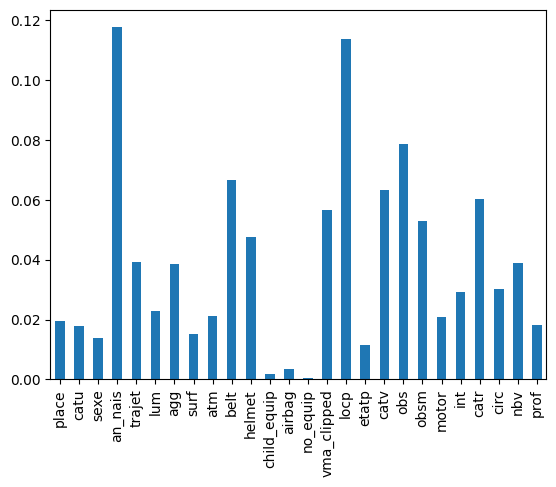

In [46]:
rf_importances = pd.Series(rf.feature_importances_, index=columns_to_keep)
rf_importances.plot.bar()
# n.b. One should treat this information with caution.
# Indeed, numerical attributes tend to be more often chosen as a split, because they are harder to learn than, for instance, binary attributes.
# As a consequence, they may naturally end up with a higher feature importance

feature importances are calculated as a mean decrease of impurity. They are weighted by the probability of reaching that node (it could be approximated as proportion of samples there). Additionally, it is averaged over all trees in the random forest.

We see that most important features are: year of birth, location of pedestrian, obstacle, usage of belt, etc.

## XGBoost
⏩ Train a XGBoost classifier, using the default parameters.

Provide the accuracy score and the AUC.

Try to change the `learning_rate` and `n_estimators` parameters

In [47]:
# !pip install xgboost
import xgboost
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(x_train, y_train0)

print("Accuracy score: ", accuracy_score(xgb.predict(x_test), y_test0))
print("Area under the ROC curve: ", roc_auc_score(y_test0, xgb.predict_proba(x_test)[:,1]))

Accuracy score:  0.8557823749202588
Area under the ROC curve:  0.8579780750057434


In [48]:
accuracy = []
eta_range = list(map(lambda x: x/100.0, range(10, 40, 5)))
estimators_range = range(50, 350, 50)
x = []
y = []
for eta in eta_range:
  for n_estimators in estimators_range:
    xgb = XGBClassifier(n_estimators=n_estimators, eta=eta)
    xgb.fit(x_train, y_train0)
    score = accuracy_score(xgb.predict(x_test), y_test0)
    # print(f"eta={eta}, estim={n_estimators}, Accuracy = {score}")
    accuracy.append(score)
    x.append(eta)
    y.append(n_estimators)



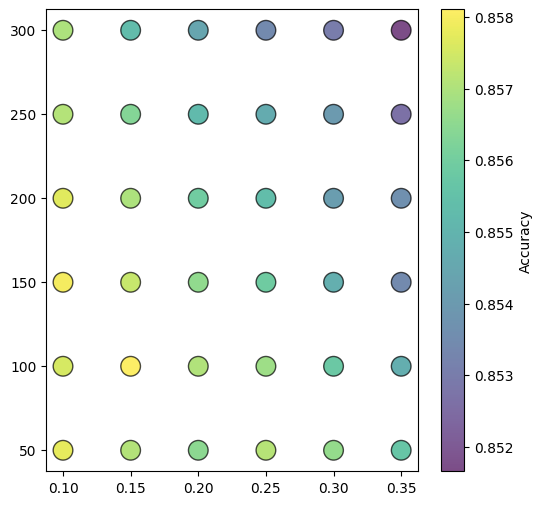

In [49]:
fig, ax = plt.subplots(figsize=(6, 6))
scatter = ax.scatter(x, y, linewidths=1, alpha=0.7, edgecolor='k', s=200, c=accuracy)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, label='Accuracy')

plt.show()

Thus, slightly better performance could be achieved by lowering the learning rate, and increasing the number of estimators along with that.

## Logistic regression

We now compare the result to logistic regression. To this end, we first need to onehot encode all categorical columns. We use sklearn onehotencoder.

⏩ Fill the code below

In [50]:
from sklearn.preprocessing import OneHotEncoder

categorical_features = ['place', 'catu', 'sexe',
       'trajet', 'lum', 'agg','surf',
       'atm',  'belt', 'helmet', 'child_equip', 'airbag', 'no_equip',
       'locp',  'etatp', 'catv', 'obs', 'obsm', 'motor', 'int','catr', 'circ', 'nbv', 'prof']

ec = OneHotEncoder()

dummy_cols = ec.fit_transform(x_train[categorical_features])

⏩ What is the type of `dummy_cols`? What is the interest of using this type?

In [51]:
type(dummy_cols)

scipy.sparse._csr.csr_matrix

In [52]:
dummy_cols.data.nbytes/dummy_cols.toarray().data.nbytes

0.13186813186813187

This data type, as could be seen, is almost 10 times better than array. The thing is that one hot encoding produces sparse matrices, which are filled with zeros, and rarely with ones. Thus, to save space csr_matrix saves only the locations and values of non-zero numbers, rather than the whole matrix, as the usual array does.

In this example, not all the attributes are categorical. We use ColumnTransformer in order to one-hot encode the categorical columns, and leave the remaining columns unchanged.

In [53]:
from sklearn.compose import ColumnTransformer
transformer=ColumnTransformer( transformers=[('OneHot',OneHotEncoder(handle_unknown='ignore'),categorical_features)],remainder="passthrough")
x_train_oh = transformer.fit_transform(x_train)

We print the first line: notice the dummy variables and the numerical variable at the end.

In [54]:
x_train_oh.toarray()[0]

array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
       1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
       0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
       1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 

⏩ How many rows/colums does x_train_oh contains?

In [55]:
x_train_oh.shape

(85201, 184)

it contains 184 columns, and 85201 rows

Some columns have only a small number of ones. Here, we decide to delete these columns before training/ Of course, smarter approaches could be used (more detailed EDA, Lasso, etc.)

In [56]:
number_of_ones = sum(x_train_oh).toarray()

In [57]:
cols = [ i for i in range (184) if number_of_ones[0][i]>200]
x_train_lr = x_train_oh[:,cols]

⏩ Fit a logistic regression

In [58]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(x_train_lr, y_train0)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

We transform x_test similarly to x_train, using the previous ColumnTransformer

In [59]:
x_test_oh = transformer.transform(x_test)
x_test_lr = x_test_oh[:,cols]

⏩ Provide the accuracy and the AUC of the logistic regression

In [60]:
print("Accuracy score: ", accuracy_score(lr.predict(x_test_lr), y_test0))
print("Area under the ROC curve: ", roc_auc_score(y_test0, lr.predict_proba(x_test_lr)[:,1]))

Accuracy score:  0.8501093593365534
Area under the ROC curve:  0.8316523494247949


# PART 3. Multiclass classification

We now would like to predict the class (1,2,3,4) in the `grav` label). Recall that 1=free, 2=killed, 3=severe_injury, 4=slight_injury

⏩ Fit a `LogisticRegression` classifier using the argument `multi_class='multinomial'`. What is the name of the loss function used by this classifier?

In [82]:
lr = LogisticRegression(multi_class="multinomial")
y_train1 = y_train["grav"]
lr.fit(x_train_lr, y_train1)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

cross entropy loss is used

The next cells give an example of the output classifier, in terms of scores and hard decisions

In [62]:
print("Output probabilities of the 0th test input: ",lr.predict_proba(x_test_lr[0]))
print("Hard decision of the 0th test input: ", lr.predict(x_test_lr[0]), "... that is the argument of the maximum probability")

Output probabilities of the 0th test input:  [[0.6833933  0.01920481 0.11181496 0.18558694]]
Hard decision of the 0th test input:  [1] ... that is the argument of the maximum probability


⏩ Print the confusion matrix, and provide your comment about its structure. Explain.

In [90]:
from sklearn.metrics import confusion_matrix
print("Confusion Matrix")
print(confusion_matrix(lr.predict(x_test_lr),y_test["grav"]))
print("Number of labels in the training dataset")
y_train1.value_counts()

Confusion Matrix
[[14838   315  1629  6820]
 [    0     0     0     0]
 [  182   170   729   326]
 [ 3741   627  4095 10420]]
Number of labels in the training dataset


1    36347
4    34115
3    12632
2     2107
Name: grav, dtype: int64

This matrix provides us with information how often labels are confused with each other. The columns are predicted label (1,2,3,4), and in the rows, the actual values. For example, the value in row 3, col 1, means that 167 times a sample was assigned label 1 when the true label was 3.

Values on diagonal show the amount of correct assignments.

we see that no samples were classified with label 2 = "killed". This can be explained with very small number of data samples with label 2 in the training data. Only 2107 samples, that is, only 2% of dataset has this lable.

⏩ Re-train a logistic classifier, but now use the argument `class_weight='balanced'`. Observe the confusion matrix. Explain.

In [77]:
lr = LogisticRegression(multi_class="multinomial", class_weight='balanced')
lr.fit(x_train_lr, y_train1)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', multi_class='multinomial')

When class_weight is not specified, all weights are automatically set to 1. When using "balanced", it will set larger weight, for classes that are less frequent in the training data.

<Axes: >

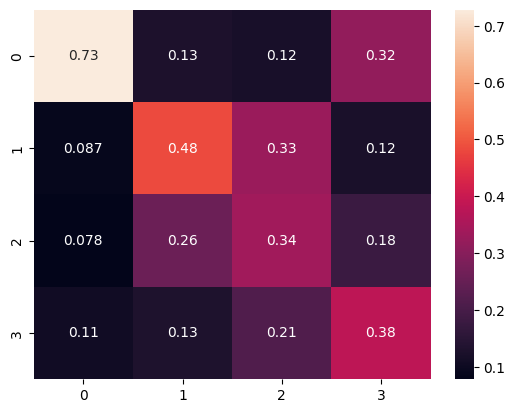

In [78]:
# We normalize the confusion matrix in such a way that every column has a sum equal to one
confmat = confusion_matrix(lr.predict(x_test_lr),y_test.grav)
confusion_probabilities = confmat / sum(confmat)
sns.heatmap(confusion_probabilities,annot=True)


This fixed the problem that we had. As the class 2 ("killed") was given bigger weight, it was learned more properly. Now model classifies 48% of labels of this class correctly.

⏩ Train a random forest (using `class_weight='balanced'`) and plot the (normalized) confusion matrix

<Axes: >

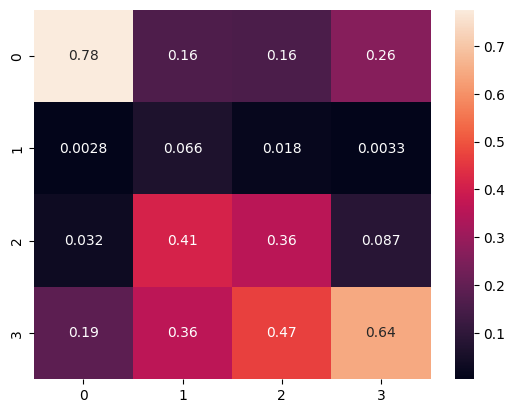

In [95]:
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(x_train, y_train1)

confmat = confusion_matrix(rf.predict(x_test),y_test.grav)
confusion_probabilities = confmat / sum(confmat)
sns.heatmap(confusion_probabilities,annot=True)

Even with the balanced class weights, random forest performs poorly to identify correctly 2nd class. However, in comparison with Logistic Regression, it identifies class 4 much better.

In order to compare the performance of two classifiers using a single measure, one option is to compute the log_loss, or cross entropy loss [see here](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression)

To this end we first need, to format the label column using a `LabelBinarizer`


In [66]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit(y_train.grav)

LabelBinarizer()

In [67]:
# Here is what the LabelBinarizer output looks like
lb.transform(y_test.grav)

array([[1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       ...,
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

In [68]:
# To be compared with the output probability scores
rf.predict_proba(x_test)

array([[0.95780588, 0.04219412],
       [0.4349697 , 0.5650303 ],
       [0.56619893, 0.43380107],
       ...,
       [0.79785575, 0.20214425],
       [0.86569369, 0.13430631],
       [0.85526663, 0.14473337]])

⏩ Compare the log_loss of random forest to logistic regression, and to XGBoost.

In [104]:
from sklearn.metrics import log_loss
print("Loss of random forest")
print(log_loss(y_test.grav, lb.transform(rf.predict(x_test))))
print("Loss of logistic regression")
print(log_loss(y_test.grav, lb.transform(lr.predict(x_test_lr))))
print("Loss of XGboost")
print(log_loss(y_test.grav, lb.transform(xgb.predict(x_test))))

Loss of random forest
12.83437206822455
Loss of logistic regression
14.703399570129921
Loss of XGboost
5.016394518345661


We see that XGboost has much smaller loss.

# Conclusion

In this notebook, we have seen how to

*   Perform an EDA (although more could have been done)
*   Clean up a data set
*   Use random forest and XGBoost
*   Use sklearn onehotencoder, columnencoder
*   Handle mutliclass classification using log_loss, confusion matrices
*   Deal with unbalanced data sets

